<h2>Import Preprocessed Data</h2>

In [8]:
#Custom function for data cleaning and preprocessing 
from dataCleaning import *    
from dataPreprocessing import *                         
df = dataCleaning('./CSV/iphone_dataset.csv')
df = dataPreprocessing(df)

In [9]:
mydf = df
def categorize(row):
    if row['review_helpful_vote'] <= 10:
        return 0
    elif row['review_helpful_vote'] > 10 and row['review_helpful_vote'] <= 100:
        return 1
    elif row['review_helpful_vote'] > 100:
        return 2


# mydf['helpfulness'] = mydf.apply(lambda row :categorize(row), axis = 1)
mydf['helpfulness'] = mydf['review_helpful_vote'] > 0

mydf.head()

review_rating  review_helpful_vote  \
0              3                 5087   
1              1                 2822   
2              5                 1798   
3              1                 1366   
4              5                  536   

                                              review  \
0                                              note    
1  very bad experience with this iphone xr phone ...   
2  amazing phone with amazing camera coming from ...   
3  so i got the iphone xr just today  the product...   
4  i have been an android user all my life until ...   

                                          lemmatized  helpfulness  
0                                             [note]         True  
1  [bad, experience, iphone, xr, phone, back, cam...         True  
2  [amazing, phone, amazing, camera, coming, ipho...         True  
3  [got, iphone, xr, today, product, look, amazin...         True  
4  [android, user, life, decided, try, iphone, xr...         True

In [12]:
mydf.drop(mydf[(mydf['review_helpful_vote'] == 0) & (mydf['review'].apply(lambda x:len(x.split())) < 10)].index,inplace = True)

<h2>Word2Vec Embeddings</h2>

In [13]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(mydf['lemmatized'], mydf['helpfulness'], test_size = 0.3)
# text_tokens = mydf['lemmatized'].tolist()[1:]
# model = Word2Vec(sentences=text_tokens, vector_size=100, window=5, min_count=4, workers=4,sg=1)
model = Word2Vec(X_train, vector_size=100, window=5, min_count=2)

In [18]:
model.wv['iphone']

array([-0.23210667,  0.41059563,  0.05479554,  0.2363475 ,  0.14150801,
       -1.0204414 ,  0.27051342,  1.062146  , -0.580228  , -0.3105518 ,
       -0.34858626, -0.7892051 , -0.17581414,  0.27666742,  0.08490781,
       -0.559883  ,  0.13767104, -0.7503281 , -0.06517247, -0.9959209 ,
        0.47054562,  0.25741342,  0.17226909, -0.1284568 , -0.16980717,
       -0.0619631 , -0.45434365, -0.53218246, -0.50653076,  0.21354502,
        0.59033567,  0.1306407 ,  0.08395875, -0.52202904, -0.11856765,
        0.8154057 ,  0.04068578, -0.41741097, -0.31763238, -1.0356929 ,
        0.13889165, -0.654542  , -0.04184394,  0.00342748,  0.35423237,
       -0.313699  , -0.44421083,  0.01576614,  0.29232398,  0.26853624,
        0.37174237, -0.31782278,  0.05272919, -0.09914713, -0.28214008,
        0.24194475,  0.4967061 ,  0.08829951, -0.4680235 ,  0.21691148,
        0.31685683,  0.22249357,  0.01825811, -0.21062452, -0.75484854,
        0.5618763 ,  0.4037822 ,  0.61076915, -0.73239374,  0.66

<h3>Data Analysis using Embeddings</h3>

In [ ]:
# Top 10 most similar words 
sims = model.wv.most_similar('iphone', topn=10)
sims

[('apple', 0.999664843082428),
 ('gb', 0.9996500015258789),
 ('go', 0.9996466636657715),
 ('much', 0.9996383190155029),
 ('experience', 0.9996351599693298),
 ('model', 0.9996249079704285),
 ('phone', 0.99962317943573),
 ('think', 0.9996156096458435),
 ('xr', 0.9996151328086853),
 ('device', 0.9996131658554077)]

c:\Users\hp\anaconda3\envs\felix_env\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\hp\anaconda3\envs\felix_env\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


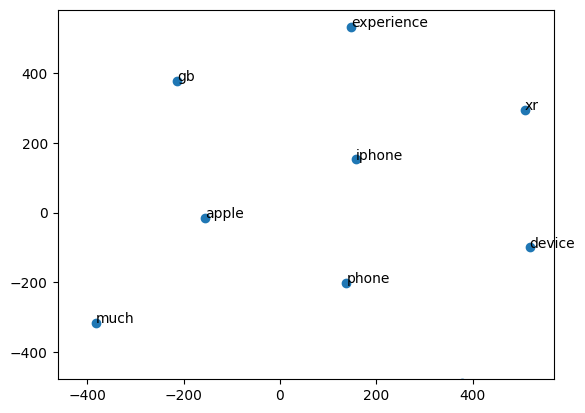

In [ ]:
from tsne_closest_words import *
display_closestwords_tsne_plot(model,'iphone')

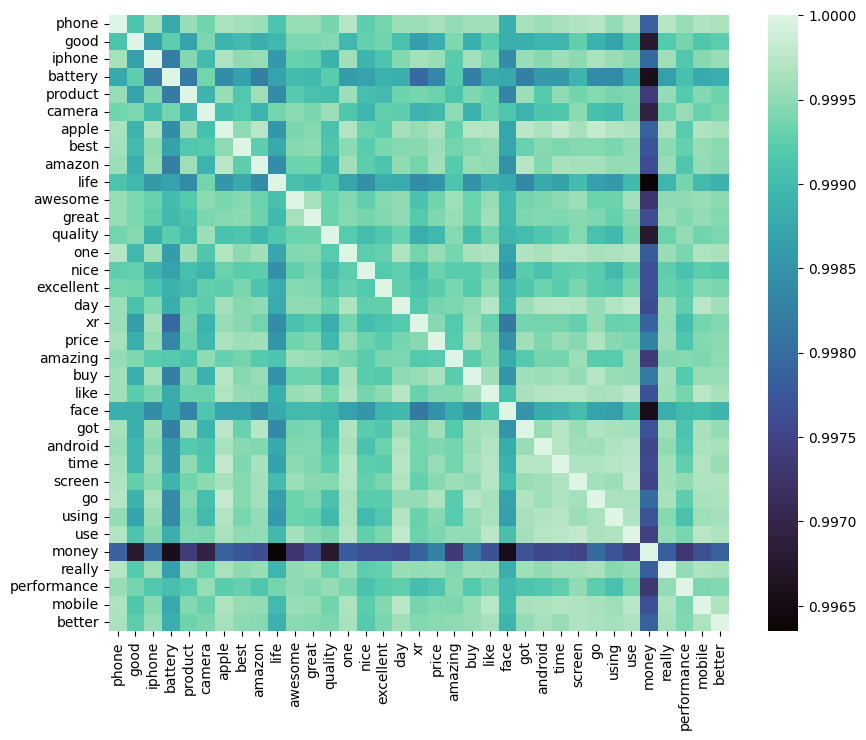

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns 

words = mydf['lemmatized']
allwords = []
embeddings_vector = []

for wordlist in words:
    allwords += wordlist
    
from nltk.probability import FreqDist
mostcommon = FreqDist(allwords).most_common(35)
for word,freq in mostcommon:
    embeddings_vector.append(model.wv[word])
embeddings_vector = np.array(embeddings_vector)

sim_matrix = cosine_similarity(embeddings_vector)
mostcommon = [word for word,freq in mostcommon]
sims_df = pd.DataFrame(sim_matrix,columns = mostcommon)
sims_df.index = mostcommon


plt.figure(figsize = (10,8))
sns.heatmap(sims_df, cmap = 'mako')
plt.show()

<h2>Training ML Model</h2>

In [19]:
words = set(model.wv.index_to_key)
X_train_vect = np.array([np.array([model.wv[i] for i in ls if i in words]) for ls in X_train])
X_test_vect = np.array([np.array([model.wv[i] for i in ls if i in words]) for ls in X_test])

X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100,dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100,dtype=float))

C:\Users\hp\AppData\Local\Temp\ipykernel_14748\1187906084.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([model.wv[i] for i in ls if i in words]) for ls in X_train])
C:\Users\hp\AppData\Local\Temp\ipykernel_14748\1187906084.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([model.wv[i] for i in ls if i in words]) for ls in X_test])


<h3>Random Forest Classifier</h3>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix



In [ ]:
rf = RandomForestClassifier(class_weight={0: 380,1 : 1700})
rf_model = rf.fit(X_train_vect_avg,y_train.values.ravel())
y_pred = rf_model.predict(X_test_vect_avg)
confusion_matrix(y_test,y_pred)


In [ ]:
lr = LogisticRegression(class_weight={0:300},max_iter=1000)
lr_model = lr.fit(X_train_vect_avg,y_train.values.ravel())
y_pred = lr_model.predict(X_test_vect_avg)
confusion_matrix(y_test,y_pred)

(array([1106.,  174.,   25.,   20.]),
 array([  1,   4,  25,  50, 100]),
 <BarContainer object of 4 artists>)

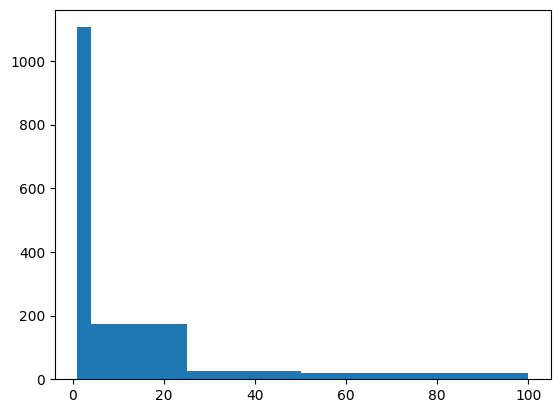

In [ ]:
plt.hist(mydf.loc[mydf['review_helpful_vote'] != 0, 'review_helpful_vote'], bins = [1,4,25,50,100])

In [ ]:
mydf.loc[mydf['review_helpful_vote'] != 0, 'review_helpful_vote'].describe()

count    1357.000000
mean       25.574060
std       244.217684
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max      5087.000000
Name: review_helpful_vote, dtype: float64